Подгружаемые библиотеки

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, int32
from tabulate import tabulate


TPB = 16
ITER = 8
EPS = 10e-6

Функция суммирования элементов вектора на CUDA.

Распораллеливание происходит таким образом, что нити работают с разными элементами (в зависимости от id нити) и суммируют. В момент, когда нужно перезаписать переменную, хранящую результирующее выражение, происходит блокировка переменной с помощью atomic, чтобы избежать ситуации, когда несколько потоков захотят изменить одну и ту же переменную.

In [ ]:
@cuda.jit
def gpu_vec_sum(vec, res):
    tx = cuda.threadIdx.x
    bx = cuda.blockIdx.x
    idx = tx + bx * TPB
    if idx < vec.shape[0]:
      cuda.atomic.add(res, 0, vec[idx])

В данной функции происходит инициализация данных, пересылка данных между хостом и девайсом, замер времени выполнения параллельного суммирования элементов вектора, а также последовательного варианта программы. После выполнения вычисления на GPU результат отправляется обратно на хост.

In [ ]:
def calculation():
    rows = [] 
    vec_size_min = 1_000 
    vec_size_max = 1_000_000
    vec_size_interval = 50_000
    for vec_size in range(vec_size_min, vec_size_max + 1, vec_size_interval):
        cpu_time_sum = 0.
        gpu_time_sum = 0.
        for _ in range(ITER):
            vec = np.ones(vec_size)
            res = np.zeros(1, dtype=np.int32)

            d_vec = cuda.to_device(vec)
            d_res = cuda.to_device(res)
            start = time.time() 
            gpu_vec_sum[int((vec_size + TPB) / TPB), TPB](d_vec, d_res)
            gpu_time_sum += time.time() - start
            res = d_res.copy_to_host()

            start = time.time()
            real_res = np.sum(vec)
            cpu_time = time.time() - start
            cpu_time_sum += cpu_time

        row = [vec_size,  cpu_time_sum / ITER, gpu_time_sum / ITER]
        rows.append(row)
    print(tabulate(rows, headers=['vector size', 'cpu, ms', 'gpu, ms']))
    return rows

Функция отрисовки графиков

In [ ]:
def plots(vec_array, cpu_time_array, gpu_time_array, acceleration_array):
    # график времени работы программы на CPU
    plt.figure()
    plt.title("CPU")
    plt.plot(vec_array, cpu_time_array)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    # график времени работы программы на GPU
    plt.figure()
    plt.title("GPU")
    plt.plot(vec_array, gpu_time_array)
    plt.xlabel("vector size")
    plt.ylabel("time, ms")
    plt.grid()

    # график ускорения вычислений на GPU относительно CPU
    plt.figure()
    plt.title("ACCELERATION")
    plt.plot(vec_array, acceleration_array)
    plt.xlabel("vector size")
    plt.ylabel("gpu to cpu, times")
    plt.grid()


/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 63 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


  vector size      cpu, ms      gpu, ms
-------------  -----------  -----------
         1000  2.25306e-05  0.0126684
        51000  4.01437e-05  9.75132e-05
       101000  5.48363e-05  0.00010556
       151000  6.61314e-05  9.90331e-05
       201000  9.07183e-05  9.93311e-05
       251000  0.000106037  0.000104517
       301000  0.000130117  0.000100583
       351000  0.00021553   0.000238776
       401000  0.000196427  0.000116259
       451000  0.000183642  0.000115156
       501000  0.00020507   0.000103593
       551000  0.000215083  0.000100851
       601000  0.00022912   0.00010705
       651000  0.000248462  0.000104159
       701000  0.000290513  0.00013867
       751000  0.00028944   0.000108838
       801000  0.000363618  0.000108719
       851000  0.000383377  0.000104129
       901000  0.000385761  0.000102162
       951000  0.000427455  0.000103205


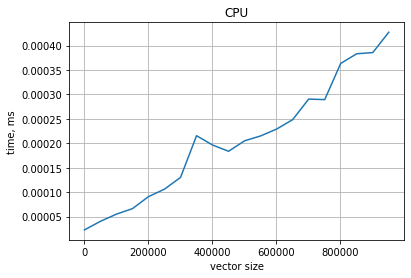

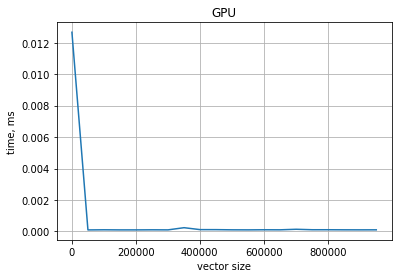

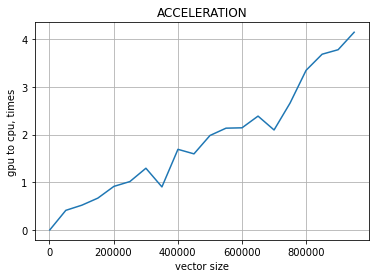

In [ ]:
output_data = calculation()

# for plots
vec_array = list(map(lambda x: x[0], output_data))
cpu_time_array = list(map(lambda x: x[1], output_data))
gpu_time_array = list(map(lambda x: x[2], output_data))
acceleration_array = list(map(lambda x: x[1] / (x[2] if x[2] > EPS else EPS), output_data))

plots(vec_array, cpu_time_array, gpu_time_array, acceleration_array)